In [574]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import ks_2samp

%matplotlib inline

In [575]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 500

In [576]:
# read data
df = pd.read_csv('../data/player_statistics.csv')

In [577]:
# Load match_info.csv
match_info = pd.read_csv('../data/match_info.csv')

# Merge the age column into df based on match_id
df = df.merge(match_info[['match_id', 'age', 'home_team_int', 'away_team_int', 'int_level']], on='match_id', how='right')


All speeds are in meters per second. Distances are in meter and times are in seconds. The speed zones, however, are noted as kilometers per hour so that the first speed zone is within 0 km/h and 5 km/h, the second between 5 km/h and 10 km/h.

In [578]:
# divide columns into relevant lists
info_vars = ['tournament_id', 'match_id', 'player_id', 'team', 'age', 'int_level']
speed_vars = ['top_speed_first', 'top_speed_second', 'avg_speed_with_ball_first', 'avg_speed_with_ball_second']
time_vars = ['onfield_time_first', 'onfield_time_second']
dist_vars = ['distance_first', 'distance_second']
ac_de_vars = ['accelerations_first', 'accelerations_second', 'decelerations_first', 'decelerations_second']
zone_vars = ['time_in_speed_zone_0_5_first','time_in_speed_zone_0_5_second', 'time_in_speed_zone_5_10_first',
             'time_in_speed_zone_5_10_second', 'time_in_speed_zone_10_15_first','time_in_speed_zone_10_15_second',
             'time_in_speed_zone_15_20_first','time_in_speed_zone_15_20_second', 'time_in_speed_zone_20_25_first',
             'time_in_speed_zone_20_25_second', 'time_in_speed_zone_25_plus_first','time_in_speed_zone_25_plus_second']

In [579]:
# create a variable for team's internationality level
df['team_int'] = df['home_team_int'].where(df['team'] == 'Home', df['away_team_int'])
info_vars.append('team_int')

In [580]:
# create average speed from time and distance variables and add to speed vars
df['avg_speed_first'] = df['distance_first']/df['onfield_time_first']
df['avg_speed_second'] = df['distance_second']/df['onfield_time_second']

speed_vars.append('avg_speed_first')
speed_vars.append('avg_speed_second')

In [581]:
# Combine 'first' and 'second' columns for all variables except info_vars
for var_list in [time_vars, dist_vars, ac_de_vars]:
    for var in var_list:
        if '_first' in var:
            base_var = var.replace('_first', '')
            df[base_var] = df[var] + df[f"{base_var}_second"]
            var_list.append(base_var)

df['top_speed'] = df[['top_speed_first', 'top_speed_second']].max(axis=1)
speed_vars.append('top_speed')
df['avg_speed'] = (df['avg_speed_first'].fillna(0)*df['onfield_time_first'] + df['avg_speed_second'].fillna(0)*df['onfield_time_second'])\
                   / (df['onfield_time_first'] + df['onfield_time_second'])
speed_vars.append('avg_speed')
df['avg_speed_with_ball'] = (df['avg_speed_with_ball_first']*df['onfield_time_first'] + df['avg_speed_with_ball_second']*df['onfield_time_second'])\
                   / (df['onfield_time_first'] + df['onfield_time_second'])
speed_vars.append('avg_speed_with_ball')

In [582]:
# Combine speed zones for the whole match
for zone in ['0_5', '5_10', '10_15', '15_20', '20_25', '25_plus']:
    df[f'time_in_speed_zone_{zone}'] = df[f'time_in_speed_zone_{zone}_first'] + df[f'time_in_speed_zone_{zone}_second']
    zone_vars.append(f"time_in_speed_zone_{zone}")

In [583]:
# reorder columns
df = df[info_vars + speed_vars + time_vars + dist_vars + ac_de_vars + zone_vars]

# replace 0 values with NaN
not_info_vars = speed_vars + time_vars + dist_vars + ac_de_vars + zone_vars
df[not_info_vars] = df[not_info_vars].replace(0, np.nan)

In [584]:
# check dataframe
df.head()

,tournament_id,match_id,player_id,team,age,int_level,team_int,top_speed_first,top_speed_second,avg_speed_with_ball_first,avg_speed_with_ball_second,avg_speed_first,avg_speed_second,top_speed,avg_speed,avg_speed_with_ball,onfield_time_first,onfield_time_second,onfield_time,distance_first,distance_second,distance,accelerations_first,accelerations_second,decelerations_first,decelerations_second,accelerations,decelerations,time_in_speed_zone_0_5_first,time_in_speed_zone_0_5_second,time_in_speed_zone_5_10_first,time_in_speed_zone_5_10_second,time_in_speed_zone_10_15_first,time_in_speed_zone_10_15_second,time_in_speed_zone_15_20_first,time_in_speed_zone_15_20_second,time_in_speed_zone_20_25_first,time_in_speed_zone_20_25_second,time_in_speed_zone_25_plus_first,time_in_speed_zone_25_plus_second,time_in_speed_zone_0_5,time_in_speed_zone_5_10,time_in_speed_zone_10_15,time_in_speed_zone_15_20,time_in_speed_zone_20_25,time_in_speed_zone_25_plus
0,57,1256,7327,Home,F12,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,57,1256,7328,Home,F12,1,1,6.21,7.18,1.80,2.25,1.986644,1.860671,7.18,1.923743,2.024696,1214.44,1211.16,2425.60,2412.66,2253.57,4666.23,22.0,24.0,18.0,23.0,46.0,41.0,490.22,556.72,438.40,400.30,203.66,163.28,62.56,64.46,14.06,20.38,5.54,6.02,1046.94,838.70,366.94,127.02,34.44,11.56
2,57,1256,7329,Home,F12,1,1,NaN,7.35,NaN,2.75,NaN,2.023597,7.35,2.023597,2.750000,NaN,1211.16,1211.16,NaN,2450.90,2450.90,NaN,19.0,NaN,19.0,19.0,19.0,NaN,499.76,NaN,411.52,NaN,193.66,NaN,71.50,NaN,23.96,NaN,10.76,499.76,411.52,193.66,71.50,23.96,10.76
3,57,1256,7330,Home,F12,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,57,1256,7331,Home,F12,1,1,6.19,NaN,1.83,NaN,1.672697,NaN,6.19,1.672697,1.830000,1214.44,NaN,1214.44,2031.39,NaN,2031.39,26.0,NaN,34.0,NaN,26.0,34.0,625.70,NaN,398.42,NaN,131.68,NaN,50.26,NaN,6.40,NaN,1.98,NaN,625.70,398.42,131.68,50.26,6.40,1.98


#### Distribution of velocity per age group

In [585]:
#define x-axis values
x = np.linspace(0, 40, 100) 

#calculate pdf of Gamma distribution for each x-value
y = stats.gamma.pdf(x, a=2, scale=5)

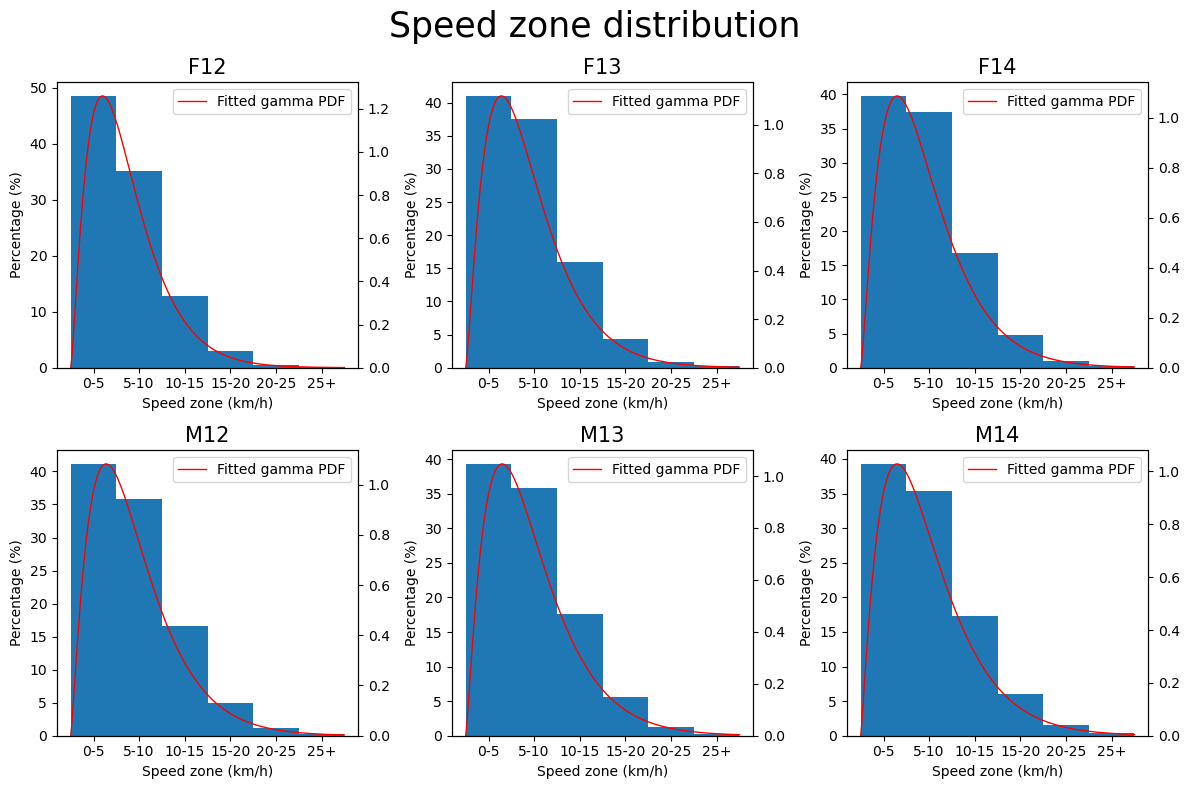

In [586]:
# plot tempo in a line plot by age groups
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

df_grouped = df.groupby('age')

# Shortened labels for speed zones
zone_labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25+']
zone_midpoints = np.array([2.5, 7.5, 12.5, 17.5, 22.5, 27.5])

bar_width = 5 # width of the speed zone (0-5, 5-10, etc.)

# save gamma parameters
gamma_params_dict = {}

for i, (group_name, df_group) in enumerate(df_grouped):
    df_zones = df_group[zone_vars]

    speed_zone_columns = [col for col in df_zones.columns if ("first" not in col) and ("second" not in col)]

    # Sum the absolute time spent in each speed zone across all matches
    summed_zones = df_zones[speed_zone_columns].sum()

    # Normalize summed values to percentages
    total_time = summed_zones.sum()
    percentage_zones = (summed_zones / total_time) * 100

    # Reconstruct pseudo-speed data for fitting (or use real speeds if available)
    pseudo_speeds = np.repeat(zone_midpoints, (percentage_zones.values * 10).astype(int))  # scaling for sample size

    # Fit gamma distribution
    gamma_params = stats.gamma.fit(pseudo_speeds, floc=0)
    gamma_dist = stats.gamma(*gamma_params)

    # Save parameters for later use
    gamma_params_dict[group_name] = gamma_params

    # Generate x values for smooth curve
    x = np.linspace(0, 30, 300)
    pdf = gamma_dist.pdf(x)

    # Scale the PDF correctly
    bin_width = 5
    pdf_scaled = pdf * bin_width
    pdf_scaled = pdf_scaled / pdf_scaled.sum() * 100  # scale to percentage
    
    axes[i].bar(zone_midpoints, percentage_zones.values, width=bar_width)
    axes[i].set_title(group_name, fontsize=15)
    axes[i].set_xlabel('Speed zone (km/h)', fontsize=10)
    axes[i].set_ylabel('Percentage (%)', fontsize=10)
    axes[i].set_xticks(zone_midpoints)
    axes[i].set_xticklabels(zone_labels)

    # Twin y-axis for the gamma PDF
    ax2 = axes[i].twinx()
    ax2.plot(x, pdf_scaled, color='red', linewidth=1, label='Fitted gamma PDF')
    ax2.tick_params(axis='y')
    ax2.set_ylim(0)  # Adjust y-axis limits for the PDF

    ax2.legend(loc='upper right')

fig.suptitle('Speed zone distribution', fontsize=25)
plt.tight_layout()

#### Speed statistic distributions

Age group: F12
KS statistic: 0.0660988219340622, p-value: 0.158214957013998
Age group: F13
KS statistic: 0.09875737529054175, p-value: 0.0006172942243096253
Age group: F14
KS statistic: 0.039202604439970444, p-value: 0.48100976730499173
Age group: M12
KS statistic: 0.08839375020455603, p-value: 0.00040756753087734155
Age group: M13
KS statistic: 0.030722482061412426, p-value: 0.7738268192255908
Age group: M14
KS statistic: 0.08164117440225035, p-value: 0.002430560362737141


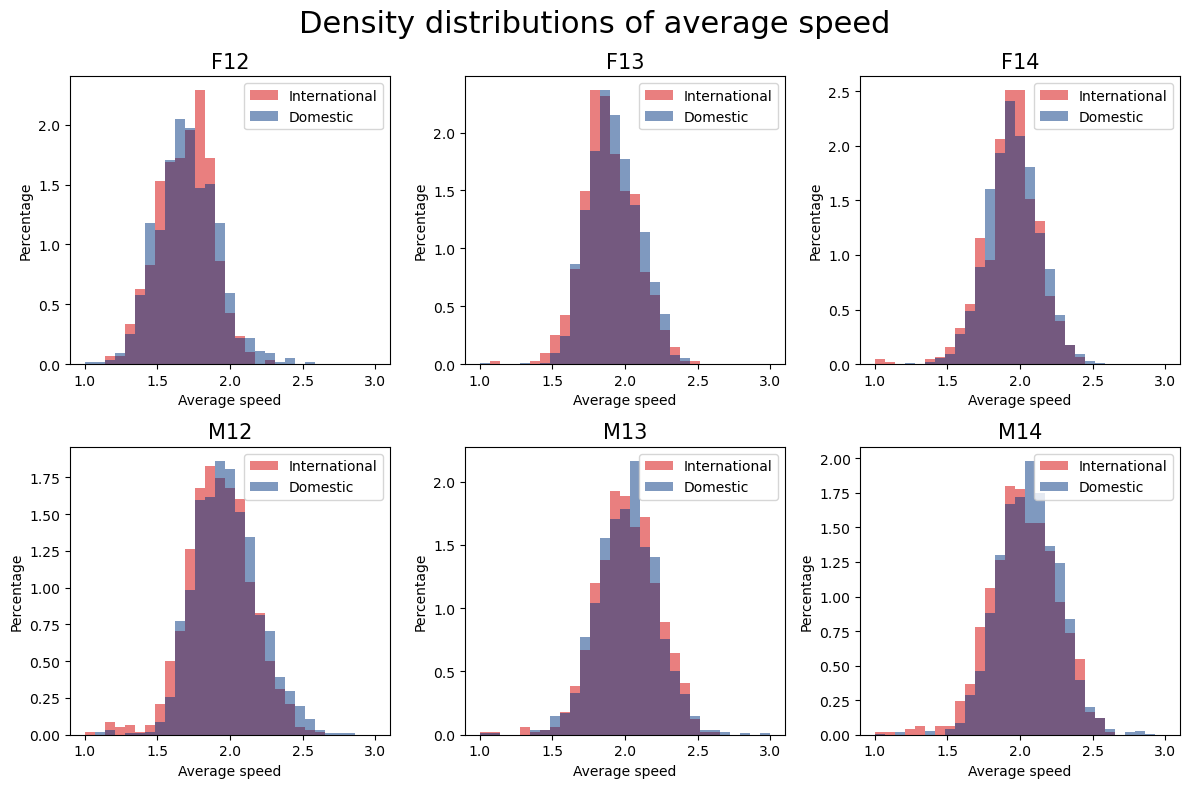

In [587]:
# create a distribution plot for the average speed
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Define colors
colors = ['#003580', '#d50000']

df_grouped = df.groupby('age')

for i, (group_name, df_group) in enumerate(df_grouped):
    avg_speed_dom = df_group.loc[df_group['team_int'] == 0, 'avg_speed']
    avg_speed_int = df_group.loc[df_group['team_int'] == 1, 'avg_speed']
    
    ax = axes[i]

    # Remove NaN values for KS test
    avg_speed_dom = avg_speed_dom.dropna()
    avg_speed_int = avg_speed_int.dropna()

    ks_stat, p = ks_2samp(avg_speed_dom, avg_speed_int)
    print(f"Age group: {group_name}")
    print(f"KS statistic: {ks_stat}, p-value: {p}")

    # Plot first histogram (overlap=True)

    ax.hist(avg_speed_int,  
        alpha=0.5, 
        label='International',
        bins=np.linspace(1.0, 3.0, 30),
        color=colors[1],
        density=True) 

    ax.hist(avg_speed_dom, 
        alpha=0.5, 
        label='Domestic',
        bins=np.linspace(1.0, 3.0, 30),
        color=colors[0],
        density=True) 

    ax.set_xlabel('Average speed', fontsize=10)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.set_title(f'{group_name}', fontsize=15)
    ax.legend(loc='upper right')

plt.suptitle("Density distributions of average speed", fontsize=22)
plt.tight_layout()
plt.show()

Age group: F12
KS statistic: 0.05793993841285985, p-value: 0.2824645949086809
Age group: F13
KS statistic: 0.06841587698909352, p-value: 0.04075103527858968
Age group: F14
KS statistic: 0.04951862838539715, p-value: 0.21271937079984696
Age group: M12
KS statistic: 0.13059119587439139, p-value: 1.849110095266115e-08
Age group: M13
KS statistic: 0.10687970252447491, p-value: 6.15981525096369e-05
Age group: M14
KS statistic: 0.06374593716143012, p-value: 0.03320432188568572


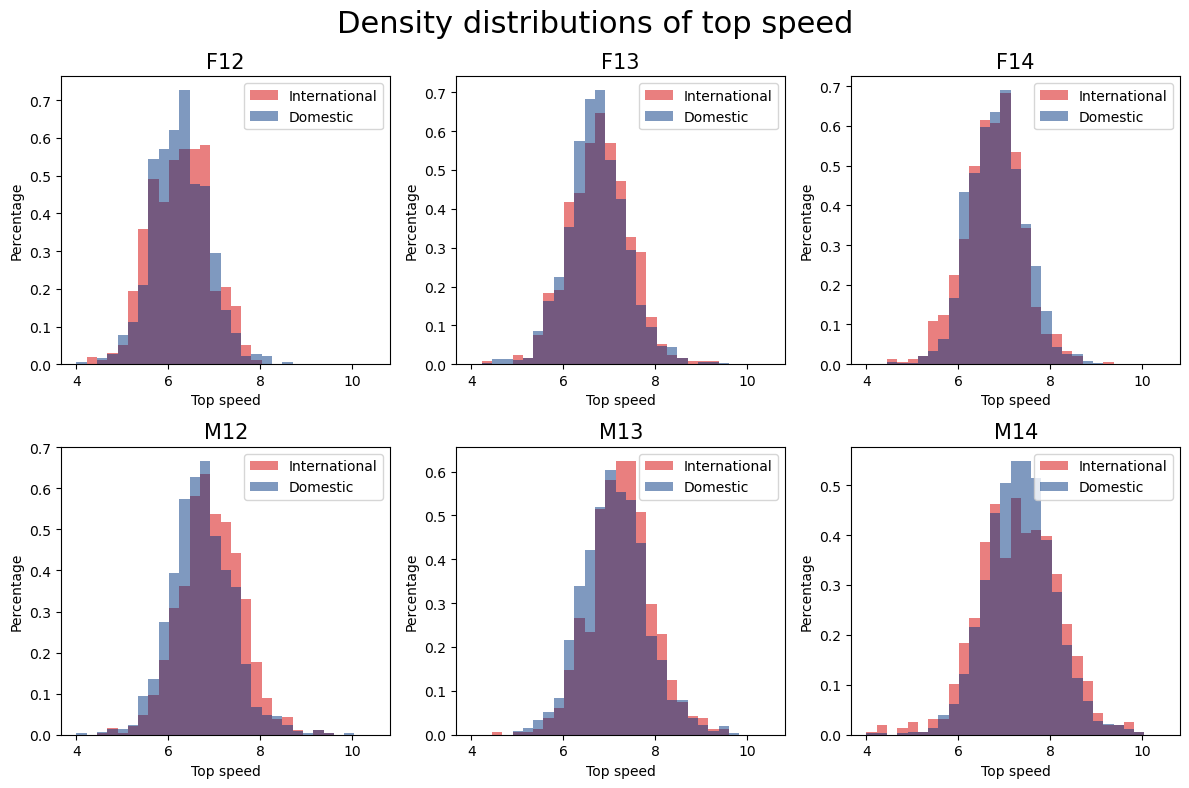

In [588]:
# create a distribution plot for the average speed
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Define colors
colors = ['#003580', '#d50000']

df_grouped = df.groupby('age')

for i, (group_name, df_group) in enumerate(df_grouped):
    top_speed_dom = df_group.loc[df_group['team_int'] == 0, 'top_speed']
    top_speed_int = df_group.loc[df_group['team_int'] == 1, 'top_speed']

    ax = axes[i]

    # Remove NaN values for KS test
    top_speed_dom = top_speed_dom.dropna()
    top_speed_int = top_speed_int.dropna()

    ks_stat, p = ks_2samp(top_speed_dom, top_speed_int)
    print(f"Age group: {group_name}")
    print(f"KS statistic: {ks_stat}, p-value: {p}")

    # Plot first histogram (overlap=True)

    ax.hist(top_speed_int,  
        alpha=0.5, 
        label='International',
        bins=np.linspace(4, 10.5, 30),
        color=colors[1],
        density=True)
    
    ax.hist(top_speed_dom, 
        alpha=0.5, 
        label='Domestic',
        bins=np.linspace(4, 10.5, 30),
        color=colors[0],
        density=True) 

    ax.set_xlabel('Top speed', fontsize=10)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.set_title(f'{group_name}', fontsize=15)
    ax.legend(loc='upper right')

plt.suptitle("Density distributions of top speed", fontsize=22)
plt.tight_layout()
plt.show()

When analysed on a team level, the average speed of players is statistically significantly higher with the Finnish teams but the top speed is higher on the international teams.

#### Match wise difference
It was said to raise the intensity of the Finnish team as well, when the other team is international so we can anlyse the difference between these two types of matches.

Age group: F12
KS statistic: 0.053854302477183834, p-value: 0.3430309889249498
Age group: F13
KS statistic: 0.0692918192918193, p-value: 0.02143495155585462
Age group: F14
KS statistic: 0.044348692913972684, p-value: 0.25299314290897074
Age group: M12
KS statistic: 0.08332207967589467, p-value: 0.0010555068893302838
Age group: M13
KS statistic: 0.040261439484838804, p-value: 0.467413976000075
Age group: M14
KS statistic: 0.0638211820534944, p-value: 0.0149950640175366


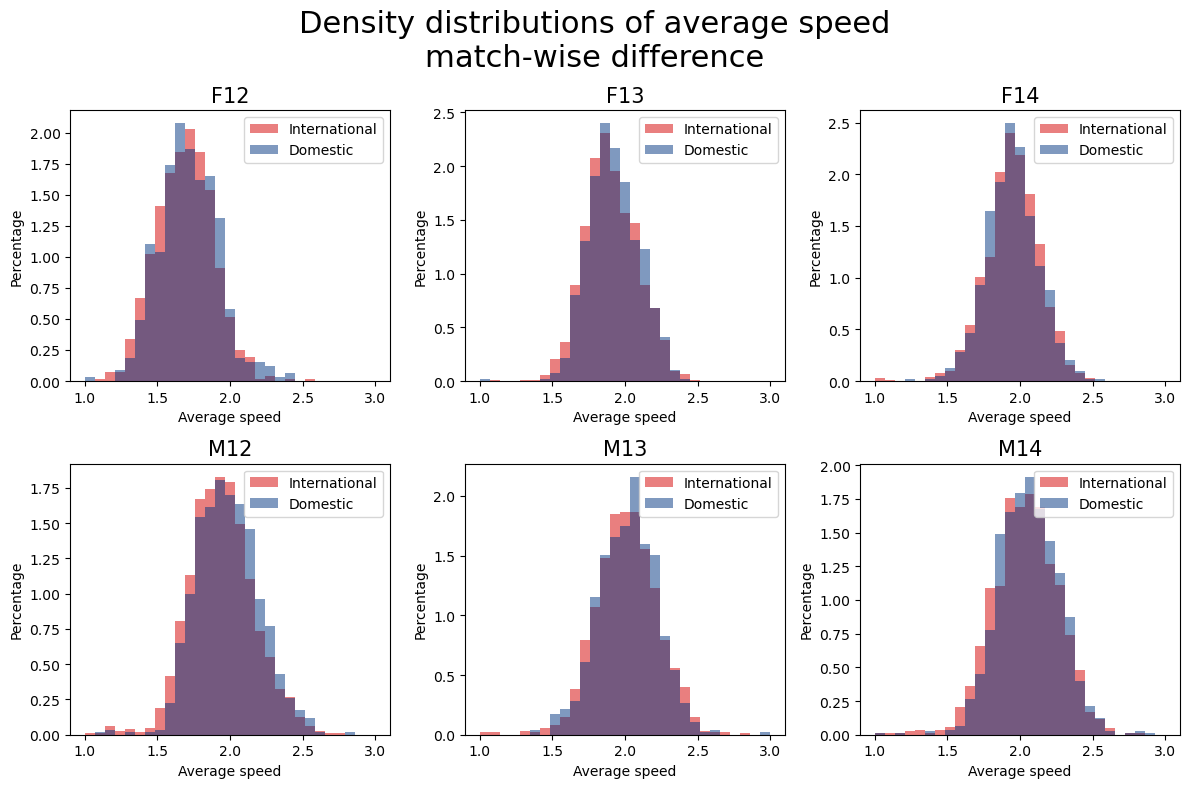

In [589]:
# create a distribution plot for the average speed
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Define colors
colors = ['#003580', '#d50000']

df_grouped = df.groupby('age')

for i, (group_name, df_group) in enumerate(df_grouped):
    avg_speed_dom = df_group.loc[df_group['int_level'] == 0, 'avg_speed']
    avg_speed_int = df_group.loc[df_group['int_level'] == 1, 'avg_speed']

    ax = axes[i]

    # Remove NaN values for KS test
    avg_speed_dom = avg_speed_dom.dropna()
    avg_speed_int = avg_speed_int.dropna()

    ks_stat, p = ks_2samp(avg_speed_dom, avg_speed_int)
    print(f"Age group: {group_name}")
    print(f"KS statistic: {ks_stat}, p-value: {p}")

    # Plot first histogram (overlap=True)

    ax.hist(avg_speed_int,  
        alpha=0.5, 
        label='International',
        bins=np.linspace(1.0, 3.0, 30),
        color=colors[1],
        density=True) 

    ax.hist(avg_speed_dom, 
        alpha=0.5, 
        label='Domestic',
        bins=np.linspace(1.0, 3.0, 30),
        color=colors[0],
        density=True) 

    ax.set_xlabel('Average speed', fontsize=10)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.set_title(f'{group_name}', fontsize=15)
    ax.legend(loc='upper right')

plt.suptitle("Density distributions of average speed\nmatch-wise difference", fontsize=22)
plt.tight_layout()
plt.show()

Age group: F12
KS statistic: 0.042101260321599304, p-value: 0.6516071885066557
Age group: F13
KS statistic: 0.07631257631257632, p-value: 0.008189739710625792
Age group: F14
KS statistic: 0.022947138944269505, p-value: 0.941199069756001
Age group: M12
KS statistic: 0.10358430252329456, p-value: 1.7373371349433698e-05
Age group: M13
KS statistic: 0.11462819036363965, p-value: 2.00067917964838e-05
Age group: M14
KS statistic: 0.07026349520837107, p-value: 0.005348596332579038


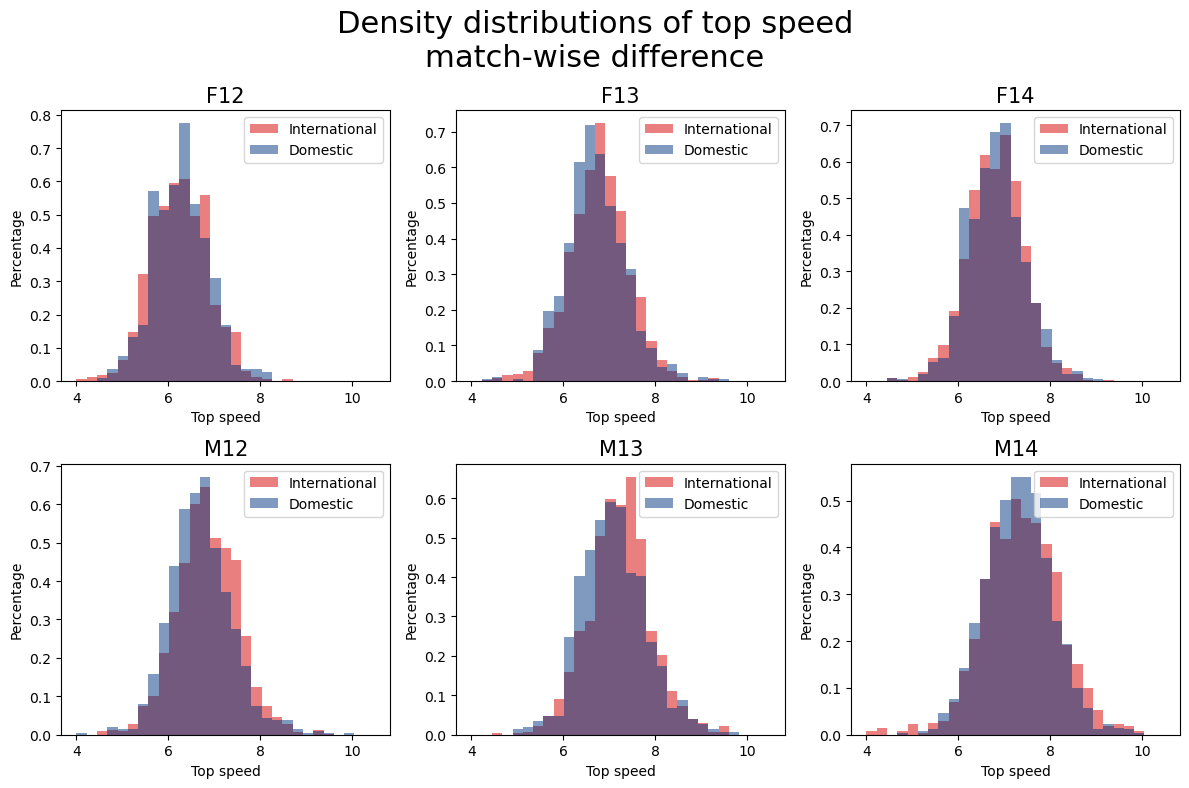

In [590]:
# create a distribution plot for the average speed
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Define colors
colors = ['#003580', '#d50000']

df_grouped = df.groupby('age')

for i, (group_name, df_group) in enumerate(df_grouped):
    top_speed_dom = df_group.loc[df_group['int_level'] == 0, 'top_speed']
    top_speed_int = df_group.loc[df_group['int_level'] == 1, 'top_speed']

    ax = axes[i]

    # Remove NaN values for KS test
    top_speed_dom = top_speed_dom.dropna()
    top_speed_int = top_speed_int.dropna()

    ks_stat, p = ks_2samp(top_speed_dom, top_speed_int)
    print(f"Age group: {group_name}")
    print(f"KS statistic: {ks_stat}, p-value: {p}")

    # Plot first histogram (overlap=True)

    ax.hist(top_speed_int,  
        alpha=0.5, 
        label='International',
        bins=np.linspace(4, 10.5, 30),
        color=colors[1],
        density=True)

    ax.hist(top_speed_dom, 
        alpha=0.5, 
        label='Domestic',
        bins=np.linspace(4, 10.5, 30),
        color=colors[0],
        density=True) 

    ax.set_xlabel('Top speed', fontsize=10)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.set_title(f'{group_name}', fontsize=15)
    ax.legend(loc='upper right')

plt.suptitle("Density distributions of top speed\nmatch-wise difference", fontsize=22)
plt.tight_layout()
plt.show()

#### Calculate intensity from load metric formula

We can calculate the intensity of a session from this formula from an academic article:

Intensity = (TD_min/TD_min_max + AcDe_min/AcDe_min_max + HID_min/HID_min_max)/3

TD_min = total distance per minute
AcDe_min = number of ac/decelerations per minute
HID_min = distance in high intensity speeds per minute, >15km/h

The max values are reference values that can be individual or generic, since the player IDs can change accross matches, we must use the generic reference value. We will take this as the maximum value of the age group.

#### Intensity calculations

Calculate distance in eacg speed zone by avg speed of zone times time. Calculate intensity.

In [591]:
# calculate distance ran in speed zones based on the time and an average speed from the zone iteratively
zone_ends = ['0_5', '5_10', '10_15', '15_20', '20_25', '25_plus']
zone_midpoints = np.array([0, 5, 10, 15, 20, 25])
for zone_end, zone_mid in zip(zone_ends, zone_midpoints):
    df[f'distance_in_speed_zone_{zone_end}'] = df[f'time_in_speed_zone_{zone_end}'] * zone_mid / 3.6  # Convert to m/s
    zone_vars.append(f'distance_in_speed_zone_{zone_end}')

# combine distances from 15 km/h and above
df['distance_in_HI_zones'] = df['distance_in_speed_zone_15_20'] + df['distance_in_speed_zone_20_25'] + df['distance_in_speed_zone_25_plus']

In [592]:
# compute intensity for each player

# needed variables
intensity_vars = ['distance', 'accelerations', 'decelerations', 'distance_in_HI_zones', 'onfield_time']
intensity_df = df[info_vars + intensity_vars].copy()

# combine accelerations and decelerations
intensity_df['ac_de'] = intensity_df['accelerations'] + intensity_df['decelerations']

# create per minute columns
intensity_df['distance_min'] = intensity_df['distance'] / (intensity_df['onfield_time'] / 60)
intensity_df['ac_de_min'] = intensity_df['ac_de'] / (intensity_df['onfield_time'] / 60)
intensity_df['distance_in_HI_zones_min'] = intensity_df['distance_in_HI_zones'] / (intensity_df['onfield_time'] / 60)

intensity_df = intensity_df.drop(columns=['tournament_id', 'match_id', 'player_id', 'team', 'ac_de', *intensity_vars])

df_grouped = intensity_df.groupby('age')

max_dict = {}

for i, (group_name, df_group) in enumerate(df_grouped):
    max_dict[group_name] = [df_group['distance_min'].quantile(0.99), df_group['ac_de_min'].quantile(0.99), df_group['distance_in_HI_zones_min'].quantile(0.99)]

# Compute intensity for each row
intensity_df['intensity'] = intensity_df.apply(
    lambda row: (
        row['distance_min'] / max_dict[row['age']][0] +
        row['ac_de_min'] / max_dict[row['age']][1] +
        row['distance_in_HI_zones_min'] / max_dict[row['age']][2]
    ) / 3 * 100,  # average and normalize to percentage
    axis=1
)

Age group: F12
KS statistic: 0.06263899184581172, p-value: 0.6076104567827116
Age group: F13
KS statistic: 0.06251669188996706, p-value: 0.13764773133167377
Age group: F14
KS statistic: 0.07529095300834432, p-value: 0.03485425797812775
Age group: M12
KS statistic: 0.04454567583544876, p-value: 0.27487658174036633
Age group: M13
KS statistic: 0.04373718377798319, p-value: 0.380447873890849
Age group: M14
KS statistic: 0.09136352732703454, p-value: 0.0007769754986695412


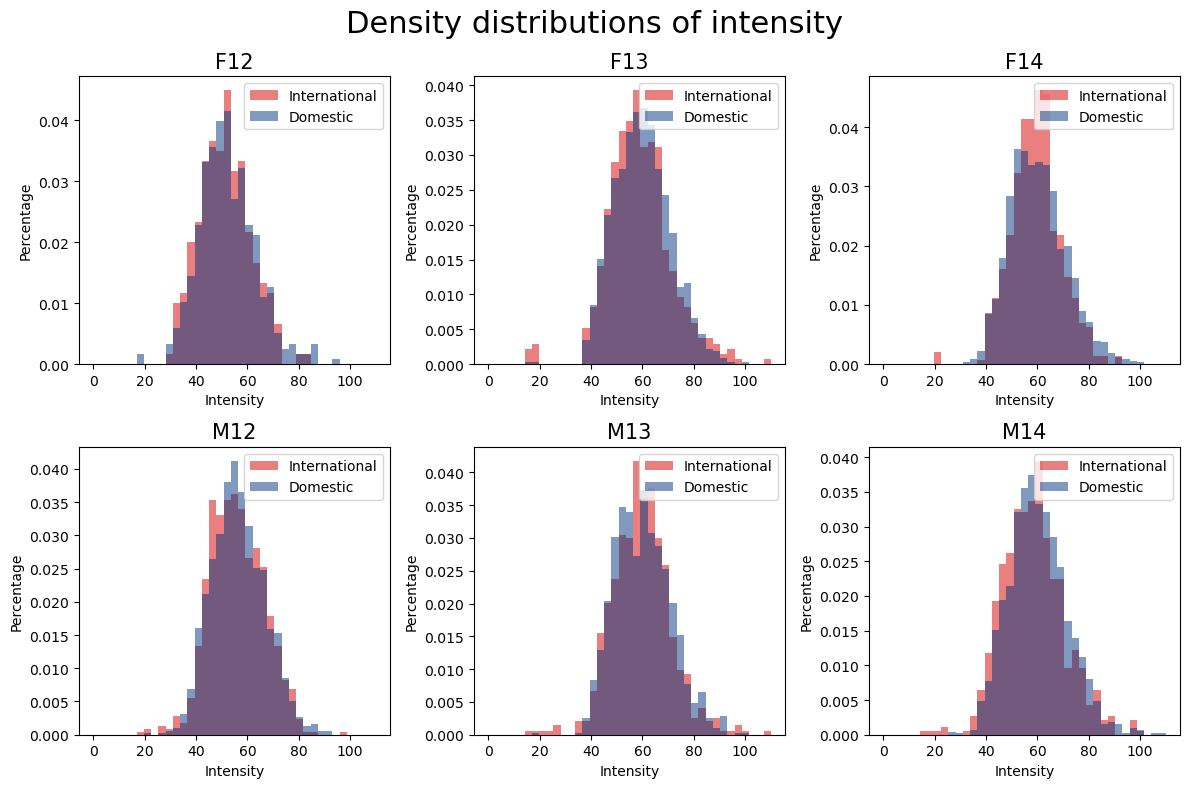

In [594]:
# create a distribution plot for the average speed
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

# Define colors
colors = ['#003580', '#d50000']

df_grouped = intensity_df.groupby('age')

for i, (group_name, df_group) in enumerate(df_grouped):
    intensity_dom = df_group.loc[df_group['team_int'] == 0, 'intensity']
    intensity_int = df_group.loc[df_group['team_int'] == 1, 'intensity']

    ax = axes[i]

    # Remove NaN values for KS test
    intensity_dom = intensity_dom.dropna()
    intensity_int = intensity_int.dropna()

    ks_stat, p = ks_2samp(intensity_dom, intensity_int)
    print(f"Age group: {group_name}")
    print(f"KS statistic: {ks_stat}, p-value: {p}")

    # Plot first histogram (overlap=True)

    ax.hist(intensity_int,  
        alpha=0.5, 
        label='International',
        bins=np.linspace(0, 110, 40),
        color=colors[1],
        density=True)

    ax.hist(intensity_dom, 
        alpha=0.5, 
        label='Domestic',
        bins=np.linspace(0, 110, 40),
        color=colors[0],
        density=True) 

    ax.set_xlabel('Intensity', fontsize=10)
    ax.set_ylabel('Percentage', fontsize=10)
    ax.set_title(f'{group_name}', fontsize=15)
    ax.legend(loc='upper right')

plt.suptitle("Density distributions of intensity", fontsize=22)
plt.tight_layout()
plt.show()